###### Catalina Rodríguez Buss
###### Astrometría 1

## **Informe 4: Inferencia Bayesiana con métodos MonteCarlo: Cadenas de Markov** 

### **1. Introducción**

En este informe se implementarán distintos conceptos y técnicas estudiadas, relacionadas con la interferencia estadística, ajustes de funciones, selección de métodos, cuadrados mínimos, interpolación y minimización. Las actividades a realizar son las siguientes:

1) Interferencia Bayesiana, para realizar el ajuste de un modelo paramétrico a un conjunto de datos.

2) Exploración del espacio de parámetros para estimar la función de **Likelihood** usando Cadenas de Markov Monte Carlo (MCMC).

3) Implementación del algoritmo **Metrópolis-Hastings** para llevar a cabo realizaciones de MCMC.

4) Interpolación de datos para construir una función contínua y derivable que pase por un conjunto de datos.

5) Minimización de funciones, mediante la técnica del **gradiente descendente**.

6) Implementación de funciones en Python. 

La interferencia estadística se puede llevar a cabo como una aplicación del **teorema de Bayes**. Si se tiene un conjunto de datos $ d $ que se puede describir mediante un modelo $ m $ con parámetros $ \phi $, se quiere calcular el mejor modelo que puede dar lugar a esos datos, es decir, maximizar la probabilidad posterior de los parámetros dados los datos para un modelo $ m $,$p(\phi|d,m)$. Esta probabilidad es proporcional al **Likelihood** $p(d|$\phi$,m)$ por la función distribución de la probabilidad anterior $ (prior,p(\phi,m)) $. 

$$ p(\phi|d,m)= \frac{p(d|\phi,m)p(\phi|m)}{p(d|m)} $$

y está normalizada por la **evidencia**, es decir, la probabilidad marginal del **Likelihood** para el modelo $ m $:

$$ p(d|m)=\int_{\Omega} p(d|\phi,m)p(\phi,m)\ d\phi $$

donde $ \Omega $ denota el espacio de parámetros.

Cuando se ajusta un modelo a un conjunto de datos, se quiere conocer la función de ***Likelihood***, $p(d|\phi,m)$, que depende de los parámetros $\phi$. Existen varios métodos para llevar esto a cabo, entre ellos se encuentran las Cadenas de Markov Monte Carlo (MCMC). En particular, el algoritmo de Metrópolis-Hastings es un método de MCMC que se utiliza para simular distribuciones multivariadas. 

### **2. Procedimiento**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### **2.1. Problema 1**

***Leer y graficar los datos pertenecientes a la función de luminosidad de galaxias obtenida por Blanton et al (2001). Los datos correspondientes a la función de luminosidad se pueden descargar del aula virtual de la materia.***

In [2]:
df=pd.read_csv('datos(1).csv')
#df['MAG'].values
df.head() # para ver solo los primeros elementos

,MAG,PHI,error_inf,error_sup
0,-23.183,0.000003,0.000002,0.000003
1,-23.020,0.000005,0.000003,0.000005
2,-22.870,0.000017,0.000005,0.000009
3,-22.698,0.000035,0.000009,0.000010
4,-22.565,0.000082,0.000024,0.000023


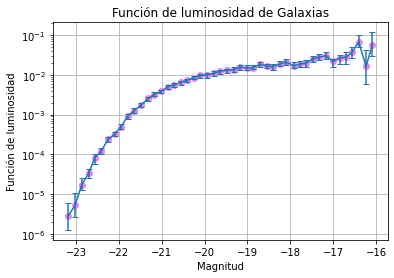

In [3]:
plt.plot(df['MAG'], df['PHI'], 'o', color='violet')
plt.title('Función de luminosidad de Galaxias')
plt.xlabel('Magnitud')
plt.ylabel('Función de luminosidad')
plt.yscale('log')
#plt.plot(df['MAG'], df['error_inf'], 'o') 
plt.errorbar(df['MAG'],df['PHI'], yerr  = [df['error_inf'],df['error_sup']], capsize = 3) #para agrear las barras de error
plt.grid()
plt.show()           

#### **2.2. Problema 2**

Se desea ajustar el modelo m al conjunto de datos $ d $, mediante un análisis Bayesiano. Para el caso de los datos del *Problema 1*, se utilizará como modelo la ***función de Schechter***:

$$\phi(M)dM = 0.4ln(10)\phi_*10^{-0.4(M-M_*)(\alpha +1)} . exp(-10^{-0.4(M-M_*)}) dM $$

Los parámetros que se intentan determinar son $\phi_*, M_*, \alpha$. Para ello hay que escribir las siguientes funciones:
1) Función de likelihood.
2) Función de priors.
3) Función de probabilidad posterior.

Estas funciones se necesitarán cuando se expore el espacio de parámetros. 

***Determine claramente los parámetros de entrada y de salida de estas funciones e impleméntelas en el programa. Explicite las hipótesis que intervienen en este planteo (especialmente respecto de los errores), la motivación de dicha hipótesis y las simplificaciones que se consiguen. Utilizando estas funciones, implementar un algoritmo de Metrópolis-Hastings para explorar el espacio de parámetros. Los parámetros del algoritmo son el largo de la cadena (un número entero) y las funciones prior. Tener en cuenta que los priors contienen el conocimiento previo sobre los datos. Los priors más comunes son funciones planas y funciones gaussianas. Explicar qué parámetros intervienen, cómo y por qué se eligen sus valores. Experimentar con distintas funciones de prior y evaluar su impacto en la realización de las cadenas.***

##### **2.2.1. Primer paso**

Se comienza realizando la función *'model'* con la fórmula de Schechter, reenombrando los parámetros de la forma 
$$ \phi_*=fi0 $$ 
$$ M_*=M0 $$
$$ \alpha=a. $$

Para verificarlo se lo grafica con los parámetros encontrados por Blanton et al. 2001, junto con los datos. Luego, se utiliza un linspace para que en el gráfico del modelo se creen puntos equispaciados tanto en el eje x, como en el y.

In [4]:
def modelo(M,fi0,M0,a):
    lista=[]
    for i in range(len(M)):
        y=0.4 * np.log(10) * fi0 * (10**(-0.4*(M[i]-M0)*(a+1))) * np.exp(-10**(-0.4*(M[i]-M0))) #schechter
        lista.append(y)
    return lista

In [5]:
cata= modelo(df['MAG'], 0.0146, -20.83, -1.2) # se define esto aca porque será utilizado más tarde
#cata

In [6]:
sx = np.linspace(-23.5, -16, 100) # los dos primeros valores son visuales del primer gráfico
sy = modelo(sx, fi0=0.0146, M0=-20.83, a=-1.2) # valores del paper de Blanton

**Gráfico del modelo**

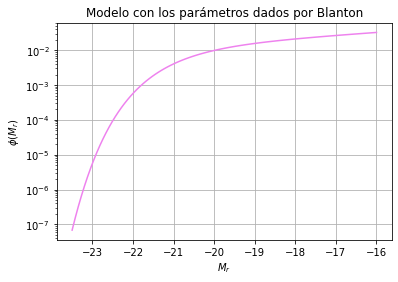

In [7]:
plt.plot(sx,sy,label='Modelo con los parámetros dados por Blanton',color='violet')
plt.title('Modelo con los parámetros dados por Blanton')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.grid()
plt.show()

**Gráfico del modelo+datos**

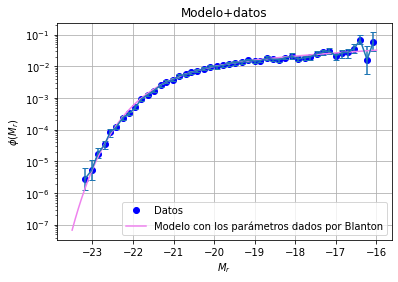

In [8]:
plt.plot(df['MAG'], df['PHI'], 'o',label='Datos',color='blue')
plt.title('Modelo+datos')
plt.xlabel('Magnitud')
plt.ylabel('Función de luminosidad')
plt.yscale('log')
#plt.plot(df['MAG'], df['error_inf'], 'o') 
plt.errorbar(df['MAG'],df['PHI'], yerr  = [df['error_inf'],df['error_sup']], capsize = 3) #para agrear las barras de error
plt.plot(sx,sy,label='Modelo con los parámetros dados por Blanton',color='violet')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.legend(fontsize=10, loc='best')
plt.grid()
plt.show()

Lo que se hace a continuación es ver de qué manera afecta cada parámetro al ajuste. Para ello, se realizan diferentes casos en los que se van variando uno u otro parámetro, observando en el gráfico a que región del modelo afecta dicho parámetro. 

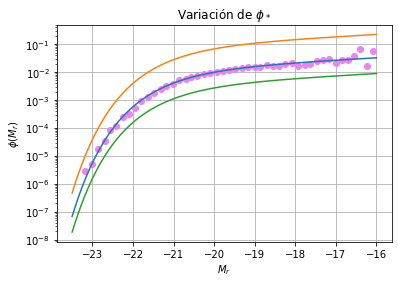

In [9]:
plt.plot(df['MAG'], df['PHI'], 'o', color='violet')
plt.xlabel('Magnitud')
plt.ylabel('Función de luminosidad')
#plt.yscale('log')
sx = np.linspace(-23.5, -16, 100) # los dos primeros valores son visuales del primer grafico
sy = modelo(sx, fi0=0.0146, M0=-20.83, a=-1.2) # se varía el primer parámetro
sy1 = modelo(sx, fi0=0.10, M0=-20.83, a=-1.2)
sy2 = modelo(sx, fi0=0.0040, M0=-20.83, a=-1.2)# uso los valores del paper de Blanton
plt.plot(sx,sy,label='Modelo con los parámetros dados por Blanton')
plt.plot(sx,sy1,label='Modelo con los parámetros dados por Blanton')
plt.plot(sx,sy2,label='Modelo con los parámetros dados por Blanton')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.title('Variación de $\phi_*$')
plt.grid()
plt.show()

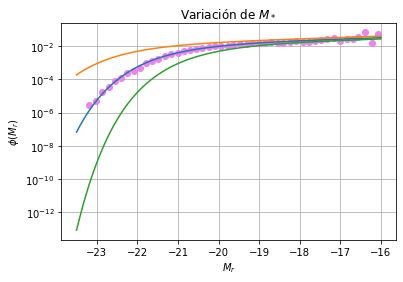

In [10]:
plt.plot(df['MAG'], df['PHI'], 'o', color='violet')
plt.xlabel('Magnitud')
plt.ylabel('Función de luminosidad')
#plt.yscale('log')
sx = np.linspace(-23.5, -16, 100) # los dos primeros valores son visuales del primer grafico
sy = modelo(sx, fi0=0.0146, M0=-20.83, a=-1.2) # se varía el segundo parámetro
sy1 = modelo(sx, fi0=0.0146, M0=-22, a=-1.2)
sy2 = modelo(sx, fi0=0.0146, M0=-20, a=-1.2)# valores del paper de Blanton
plt.plot(sx,sy,label='Modelo con los parámetros dados por Blanton')
plt.plot(sx,sy1,label='Modelo con los parámetros dados por Blanton')
plt.plot(sx,sy2,label='Modelo con los parámetros dados por Blanton')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.title('Variación de $M_*$')
plt.grid()
plt.show()

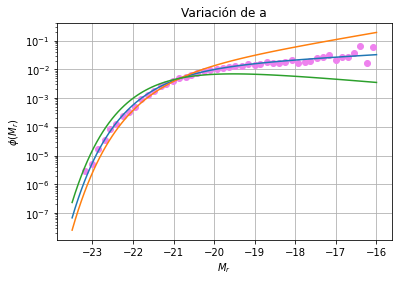

In [11]:
plt.plot(df['MAG'], df['PHI'], 'o', color='violet')
plt.xlabel('Magnitud')
plt.ylabel('Función de luminosidad')
#plt.yscale('log')
sx = np.linspace(-23.5, -16, 100) # los dos primeros valores son visuales del primer grafico
sy = modelo(sx, fi0=0.0146, M0=-20.83, a=-1.2) # se varía el tercer parámetro
sy1 = modelo(sx, fi0=0.0146, M0=-20.83, a=-1.6)
sy2 = modelo(sx, fi0=0.0146, M0=-20.83, a=-0.7)# valores del paper de Blanton
plt.plot(sx,sy,label='Modelo con los parámetros dados por Blanton')
plt.plot(sx,sy1,label='Modelo con los parámetros dados por Blanton')
plt.plot(sx,sy2,label='Modelo con los parámetros dados por Blanton')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.title('Variación de a')
plt.grid()
plt.show()

Finalmente, se deduce que $ \phi_* $ desplaza el modelo hacia arriba o hacia abajo, $ M_* $ controla la subida de la función en el eje de las magnitudes y por último, $ \alpha $ influye en la pendiente de la parte lineal.

##### **2.2.2. Segundo paso**

La siguiente pregunta que uno puede realizarse es: ¿ los parámetros presentados en el paper son realmente los mejores para ajustar los datos?. Para responder esta pregunta, lo que se hace a continuación es utilizar el likelihood, los prior y las funciones de probabilidad posterior para realizar las cadenas de Markov. De esta manera, se logra muestrear el espacio de parámetros y afirmar o no, si los parámetros del paper son realmente los mejores para el ajuste.  

Luego, el primer paso es definir a las funciones que se utilizarán. 

1) La función likelihood indica qué tan bien reproducen los datos a las predicciones del modelo. Se tiene que:

$$ p(d|\phi)= \prod_{i=1}^{N} p((M_i,\phi_i)|\phi_*, M_*, \alpha)  $$

Para calcular cada $ p((M_i,\phi_i)|\phi_*, M_*, \alpha) $ se asumen errores gaussianos. Este error se calcula para cada $ M_r  $ medido, evaluando la frecuencia $ \phi_i (=f)$ de los datos en una gaussiana centrada en el punto predicho por el modelo con parámetros fijos y sigma igual a la mitad del largo del ancho de las líneas de error. 

In [12]:
M=df['MAG']
f=df['PHI']

In [13]:
sigma= np.abs((df['error_sup'] - df['error_inf'])/2) # toma valor absoluto porque el sigma es el ancho de la gaussiana, no puede ser negativo el valor
#sigma

In [14]:
def likelihood(M,f,fi0,M0,a,sigma):
    f_modelo=modelo(M,fi0,M0,a) 
    c= 1/(np.sqrt(2*np.pi)*sigma)
    x= c*((f-f_modelo))**2/((np.sqrt(2)*sigma))**2
    likeli=-np.sum(x)/100000000 # aca multiplico todas las probabilidades
    return likeli

In [15]:
likelihood(df['MAG'],df['PHI'],0.0146,-20.83,-1.2,sigma) # Prueba con los valores del paper

-19.79369579221157

In [16]:
likelihood(M,f,0.03,-22,-1.9,sigma) # Prueba con otros valores

-1717536.660066997

Se debería ver que a medida que los parámetros utilizados se acercan más a los valores predichos por el modelo, el likelihood debe ir aumentando pues se está maximizando.

2. Para la probabilidad a priori de los parámetros se toma una distribución plana, asumiendo que no se conoce nada de los parámetros. Entonces, esta función devuelve un valor constante si se encuentra dentro de la región que se va a muestrear, mientras que es nula fuera de esa región. 

Para elegir los límites de los parámetros se prueban distintos valores y se los compara entre sí. Para ello se utiliza las pruebas realizadas anteriormente donde se concluyó que $ \phi_* $ desplaza el modelo hacia arriba o hacia abajo, $ M_* $ controla la subida de la función en el eje de las magnitudes y por último, $ \alpha $ influye en la pendiente de la parte lineal. 

Cabe remarcar que los parámetros no son independientes entre sí, por lo que para comprobar que los límites que se proponen son razonables y no quedan puntos medidos fuera de ellos, se consideran todos los modelos extremos dados por esos parámetros límites. 

In [17]:
def priors(fi0,M0,a,fi0lim, M0lim, alim):
    if (fi0lim[0]<=fi0) & (fi0<=fi0lim[1]) & (M0lim[0]<=M0) & (M0<=M0lim[1]) & (alim[0]<=a) & (a<=alim[1]):
        return 1
    else:
        return 0

In [18]:
fi0lim=[0.008,0.035]
M0lim=[-21.20,-20]
alim=[-1.66,-0.66]

In [19]:
priors(0.0146,-20.83,-1.2,fi0lim, M0lim, alim) # prueba de que funciona la función

1

3. Para la función de probabilidad posterior se utiliza el Teorema de Bayes. Si se tiene un conjunto de datos $ d $ que se puede describir mediante un modelo $ m $ con parámetros $ \phi $, se quiere calcular el mejor modelo que puede dar lugar a esos datos, es decir, maximizar la probabilidad posterior de los parámetros dados los datos para un modelo,$p(\phi|d,m)$. Por el Teorema de Bayes, esta probabilidad se puede escribir como:

$$ p(\phi|d,m)= \frac{p(d|\phi,m)p(\phi|m)}{p(d|m)} $$

donde $ p(d|\phi,m) $ es el likelihood, $ p(\phi|m) $ es la función distribución de la probabilidad posterior y $ p(d|m) $ es la evidencia. 

Como en este caso el modelo $ m $ está fijo, se tiene que:

$$ p(\phi|d)= p(d|\phi)p(\phi)$$

Luego, con esto se puede definir la función posterior.

In [20]:
def posterior(M, f, fi0, M0, a, sigma,fi0lim, M0lim, alim):
    log_pos=likelihood(M,f,fi0,M0,a,sigma) + np.log(priors(fi0,M0,a,fi0lim,M0lim,alim))
    return(log_pos)

In [21]:
# Prueba con Blanton
posterior(M, f,0.0146,-20.83,-1.2,sigma,fi0lim, M0lim, alim)

-19.79369579221157

In [22]:
# Prueba con otros valores
posterior(M, f,2.9E-2,-20.83,-1.2, sigma,fi0lim, M0lim, alim)

-1007.6283158917498

Para reafirmar que la función está andando correctamente, sería útil probar con más puntos. Como en este caso se está maximizando, al utilizar la función posterior haciendo variar en i a cada uno de los parámetros, se deberían ver curvas que suban, lleguen a un máximo y luego bajen. A continuación se realizan los tres casos.

/tmp/ipykernel_3892/4141239130.py:2: RuntimeWarning: divide by zero encountered in log
  log_pos=likelihood(M,f,fi0,M0,a,sigma) + np.log(priors(fi0,M0,a,fi0lim,M0lim,alim))


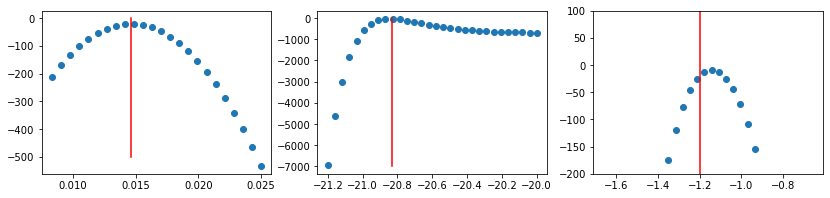

In [23]:
fi0c=np.linspace(0.004,0.025,30)
M0c=np.linspace(-21.20,-20,30)
a0=np.linspace(-1.66,-0.66,30)
a=[]
b=[]
c=[]
plt.figure(figsize = (14,3))
plt.subplot(1,3,1)
for i in range(30):
    a.append(posterior (M,f,fi0c[i],-20.83,-1.2,sigma,fi0lim,M0lim,alim))
plt.plot(fi0c,a,'o')
plt.plot([0.0146,0.0146], [-500,0],color="red")

plt.subplot(1,3,2)
for i in range(30):
    b.append(posterior (M,f,0.0146,M0c[i],-1.2,sigma,fi0lim,M0lim,alim))
plt.plot(M0c,b,'o')
plt.plot([-20.83,-20.83], [-7000,0],color="red")

plt.subplot(1,3,3)
for i in range(30):
    c.append(posterior (M,f,0.0146,-20.83,a0[i],sigma,fi0lim,M0lim,alim))
plt.plot(a0,c,'o')
plt.plot([-1.2,-1.2], [-200,600],color="red")
plt.ylim(-200,100)

plt.show()

Como se observa en los gráficos, se obtiene el comportamiento esperando en el caso de maximización. Además, se agregaron las líneas rojas que están marcando los correspondientes parámetros encontrados por Blanton para chequear que los máximos de las curvas estén próximos a esos valores. 

##### **2.2.3. Tercer paso**

Luego, ya definidas las funciones de Likelihood, probabilidad posterior y prior, resta utilizarlas para generar el algoritmo de la cadena donde buscará un punto con alguna probabilidad inicial y luego de ello, saltará a algún valor cercano, evaluará el likelihood y lo compará con el anterior. Esta comparación arrojará un resultado mayor o menor a 0. Después, si el resultado es mayor a 0, se acepta el salto a ese punto. Pero, si el resultado es menor a 0, se le da la posibilidad de saltar o no, arrojando una especie de dado.  

El primer paso es definir a la función Metropolis, la cual dentro de sus variables, tendrá a los parámetros $\phi_*$, $M_*$, $\alpha$ del ajuste. Estos últimos son una especie de 'condiciones iniciales', por lo que el usuario debe ingrearlos a mano en primera instancia. Luego, para chequear si se encuentran o no en la región de muestreo, se realiza una condicional con la función priors antes definida. Ahora, ¿ a dónde van a parar estos parámetros? si se encuentran dentro de la región de muestreo, se guardan en una matriz de N filas y 3 columnas (una para cada parámetro), y sino, no se guardan. (primeros 6 renglones)

Luego, el siguiente paso es ir moviendosé en todas las filas de la matriz de parámetros e ir completandola. Para ello se crea un for, donde los i se van a mover de 0 a (N-1). Entonces, para el primer i se calcula su posterior, y se guarda en una lista vacía. Luego, se prosigue con el siguiente, (i+1). Ahora, la pregunta es ¿cómo se define el parámetro para (i+1)?  primero, se define en función del anterior, parametros[i][col], y luego, se le suma una cantidad random, que se mueva de -1 a 1, acotada por los fi0lim, M0lim, alim, antes determinados. (6-14)

El tercer paso es calcularle la prior a ese (i+1), que dará 0 o 1. 

· Si da 1, significa que el parámetro está dentro de la región de muestreo. Luego, se prosigue a calcular su posterior y guardar ese valor dentro de una variable y. Después, se restan la posterior del punto viejo con la posterior del punto nuevo, (y-x)=z. ¿ Esto para qué es? Como se está maximizando el likelihood, se quiere que a medida que se hagan saltos, el valor de la posterior aumente. Entonces, de esta resta salen dos opciones:
   1) Si z>=0, quiere decir que efectivamente, la posterior del nuevo punto es más alta que la posteriori del viejo punto. Entonces, se acepta y se salta al nuevo punto. 
   2) En el caso contrario, se redefine z como la exponencial de z, es decir, que los valores van desde 0 a 1, y se crea una random. Entonces, si los valores de esa random son más chicos que z, se acepta el punto y se salta. Pero, si el valor del random es más grande que z, no se acepta el punto para el nuevo salto y se sigue en el mismo punto viejo. 
   
· Si da 0, no se acepta el punto nuevo y se permanece en el viejo.

Y todo esto se repite (N-1) veces. (14-33)

In [24]:
def metrop(M,f,fi0,M0,a,N,fi0lim, M0lim, alim,sigma): 
    parametros= np.zeros((N,3)) # matriz
    if priors (fi0,M0,a,fi0lim, M0lim, alim) == 1: # condicional
        parametros[0][0], parametros[0][1], parametros[0][2] = fi0,M0,a
    else:
        return('Los parámetros elegidos están fuera de la región de muestreo') # renglón 6
    post=[]
    rlist=[]
    for i in range (N-1):
        x= posterior(M, f, parametros[i][0],parametros[i][1],parametros[i][2],sigma,fi0lim,M0lim,alim)
        post.append(x)
        parametros[i+1][0]= parametros[i][0] + ((np.random.rand()*2.0)-1.0)*((fi0lim[1]-fi0lim[0])/100)
        parametros[i+1][1]= parametros[i][1] + ((np.random.rand()*2.0)-1.0)*((M0lim[1]-M0lim[0])/100)
        parametros[i+1][2]= parametros[i][2] + ((np.random.rand()*2.0)-1.0)*((alim[1]-alim[0])/100) # renglón 14
        
        if priors (parametros[i+1][0], parametros[i+1][1], parametros[i+1][2], fi0lim, M0lim, alim) == 1:
            y= posterior(M, f, parametros[i+1][0],parametros[i+1][1],parametros[i+1][2],sigma,fi0lim,M0lim,alim)
            z= y-x
            rlist.append(z)
            if z>= 0:
                continue
            else:
                z=np.exp(z)
                random=np.random.random()
                if random<z:
                    continue
                else:
                    parametros[i+1][0]=parametros[i][0]
                    parametros[i+1][1]=parametros[i][1]
                    parametros[i+1][2]=parametros[i][2]
        else:
            parametros[i+1][0]=parametros[i][0]
            parametros[i+1][1]=parametros[i][1]
            parametros[i+1][2]=parametros[i][2]
            
    return (parametros,post,rlist)

In [25]:
#metrop(M,f,0.0146,-21,-1.4,25,fi0lim,M0lim,alim,sigma) # prueba 1 :)

##### **2.2.4. Cuarto paso** 

Utilizando la función metrópolis anteriormente definida, se hará la caminata para una única cadena y dos tipos de gráficos:

1) Se hará un gráfico Parámetro1 vs Parámetro2, con lo que debería verse que los saltos que conforman a la cadena, empiezan a realizar un camino, hasta llegar a agruparse o converger en un sector y quedar oscilando alí. Este sector está al rededor, aproximadamente, de los valores de Blanton. 
2) Se graficará la posterior en función de su pasos, para verificar que efectivamente en algún momento converge.

In [26]:
parametro= metrop(M,f,0.009,-21,-0.9,2000,fi0lim, M0lim, alim,sigma)[0] # esto devuelve una matriz Nx3
pos = metrop(M,f,0.009,-21,-0.9,2000,fi0lim, M0lim, alim,sigma)[1]

In [27]:
parametro[500:,0] # ejemplo

array([0.01505061, 0.01505061, 0.01505061, ..., 0.01606161, 0.01605461,
       0.01607288])

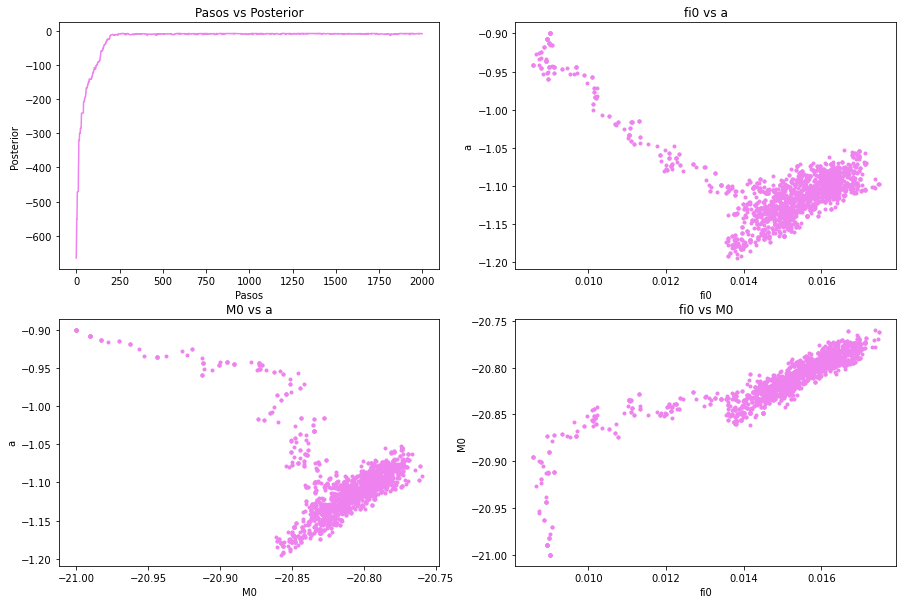

In [28]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(pos,'-',ms=3, color='violet') # grafique los pasos
plt.title('Pasos vs Posterior')
plt.xlabel('Pasos')
plt.ylabel('Posterior')

plt.subplot(2,2,2)
plt.plot(parametro[:,0],parametro[:,2],'o',ms=3,color='violet')
plt.title('fi0 vs a')
plt.xlabel('fi0')
plt.ylabel('a')

plt.subplot(2,2,3)
plt.plot(parametro[:,1],parametro[:,2],'o',ms=3,color='violet')
plt.title('M0 vs a')
plt.xlabel('M0')
plt.ylabel('a')

plt.subplot(2,2,4)
plt.plot(parametro[:,0],parametro[:,1],'o',ms=3,color='violet')
plt.title('fi0 vs M0')
plt.xlabel('fi0')
plt.ylabel('M0')

plt.show()

Por último, sería útil determinar la media y desviación estandar de cada uno de los parámetros y ver si son indistinguibles o no a los parámetros presentados en el paper de Blanton. 

In [29]:
fi0prom= np.mean(parametro[500:,0])
fi0desv= np.std(parametro[500:,0]) # std es de desv. estándar

print(fi0prom,fi0desv)

0.01574559936976555 0.0007084505174163023


In [30]:
M0prom= np.mean(parametro[500:,1])
M0desv= np.std(parametro[500:,1]) # std es de desv. estándar

print(M0prom,M0desv)

-20.8015653374426 0.016904800698827563


In [31]:
aprom= np.mean(parametro[500:,2])
adesv= np.std(parametro[500:,2]) # std es de desv. estándar

print(aprom,adesv)

-1.1089098693214203 0.023656296338712208


Luego, si bien los valores medios obtenidos no son específicamente los de Blanton, se aproximan bastante.

#### **2.3. Problemas 3 y 4**

***Visualizar las propiedades de convergencia de las cadenas. Encontrar condiciones de la simulación para las cuales se produce un mal y buen mezclado de las cadenas. Para ello realice varias cadenas y compárelas.***

***Para una elección de parámetros que produzca un buen mezclado, correr varias cadenas y compararlas.***

##### **2.3.1. Primer paso** 

Primero se realiza el experimento para crear un buen mezclado de varias cadenas, utilizando puntos bien distribuidos en el espacio de parámetros, creados por tres generadores aleatorios que respetan los extremos para cada parámetro que se encontraron anteriormente. 

Para visualizar a las cadenas y su comportamiento en el espacio de parámetros, se harán dos tipos de gráficos:

1) Se hará un gráfico Parámetro1 vs Parámetro2, con lo que debería verse que todas las cadenas arrancan en diferentes puntos, pues tienen condiciones iniciales diferentes, pero eventualmente deberían converger en una región en común. 
2) Se hará un gráfico con algún parámetro en el eje "y", y los saltos en el eje "x". Entonces, utilizando condiciones iniciales distribuidas homogéneamente, debería verse que luego de un tiempo todas las cadenas deberían converger en la misma región.

In [62]:
genfi0= np.random.random()*0.021+0.004
genM0=np.random.random()*1.2-21.20
gena=np.random.random()*1-1.66

Esto genera solo 1 cadena con 500 pasos, con sus parametros aleatorios. Pero, seria útil tener varias cadenas con todos sus parametros iniciales generados por generadores diferentes.

In [34]:
par=[]
pos=[]
for i in range (8):
    genfi0= np.random.random()*0.022+0.008
    genM0=np.random.random()*1.2-21.20
    gena=np.random.random()*1-1.66
    posterior1=metrop(M,f,genfi0,genM0,gena,2000,fi0lim, M0lim, alim,sigma)[1]
    parametros1=metrop(M,f,genfi0,genM0,gena,2000,fi0lim, M0lim, alim,sigma)[0]
    par.append(parametros1)
    pos.append(posterior1)
    

In [35]:
#par[i][:,0] # lo que se ve es que en la lista par, se guardaron 5 matrices, en las cuales en cada columna estan los 3 parametros.

In [36]:
pos[0][0] # primera lista del pos, y primer elemento (ejemplo)

-52020.402485052145

In [37]:
#d = [1,2,3,4,5] (ejemplo)
#plt.plot(d,'o')

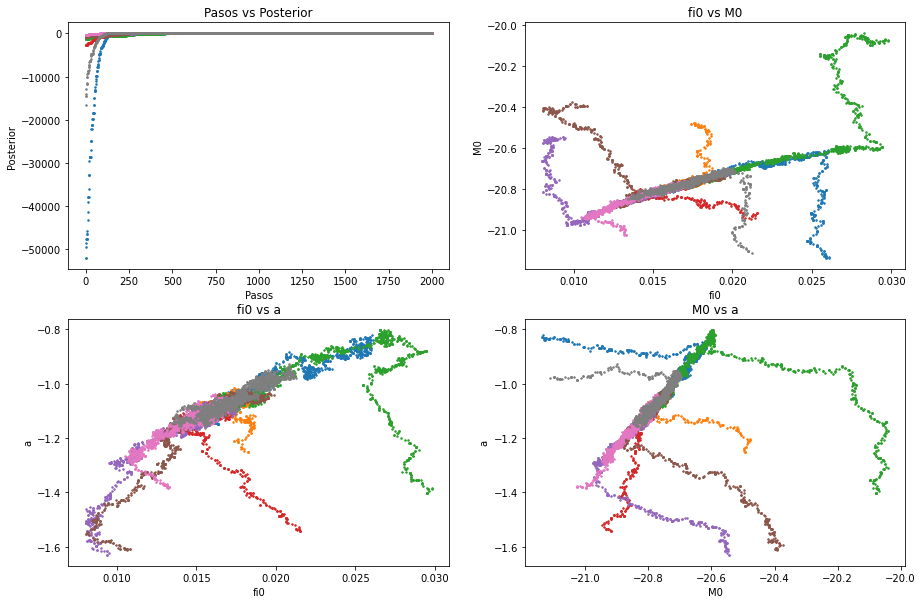

In [68]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
for i in range (8):
    plt.plot(pos[i],'.',ms=3) # grafique los pasos
plt.title('Pasos vs Posterior')
plt.xlabel('Pasos')
plt.ylabel('Posterior')

plt.subplot(2,2,2)
for i in range (8):
    plt.plot(par[i][:,0],par[i][:,1],'.',ms=3)
plt.title('fi0 vs M0')
plt.xlabel('fi0')
plt.ylabel('M0')

plt.subplot(2,2,3)
for i in range (8):
    plt.plot(par[i][:,0],par[i][:,2],'.',ms=3)
plt.title('fi0 vs a')
plt.xlabel('fi0')
plt.ylabel('a')

plt.subplot(2,2,4)
for i in range (8):
    plt.plot(par[i][:,1],par[i][:,2],'.',ms=3)
plt.title('M0 vs a')
plt.xlabel('M0')
plt.ylabel('a')


plt.show()

Resta probar con malos mezclados. La idea detrás de esto es obtener cadenas que no arrancan en puntos del espacio bien distribuidos, es decir, encontrar alguna manera de hacer que las cadenas arranquen en puntos cercanos entre ellas. Entonces, para crearlas, se utiliza una idea similar a la anterior: se crean tres generadores aleatorios, uno para cada parámetro, y en vez de utilizar los límites anteriores, se achica el intervalo. Entonces, de esta manera, se termina acotando la región desde donde pueden salir las cadenas.

In [39]:
par2=[]
pos2=[]
for i in range (10):
    genfi0= np.random.random()*0.013+0.008
    genM0=np.random.random()*0.6-21.20
    gena=np.random.random()*0.5-1.66
    posterior1=metrop(M,f,genfi0,genM0,gena,1000,fi0lim, M0lim, alim,sigma)[1]
    parametros1=metrop(M,f,genfi0,genM0,gena,1000,fi0lim, M0lim, alim,sigma)[0]
    par2.append(parametros1)
    pos2.append(posterior1)
    

In [64]:
#par2
#fi0lim=[0.008,0.035]
#M0lim=[-21.20,-20]
#alim=[-1.66,-0.66]

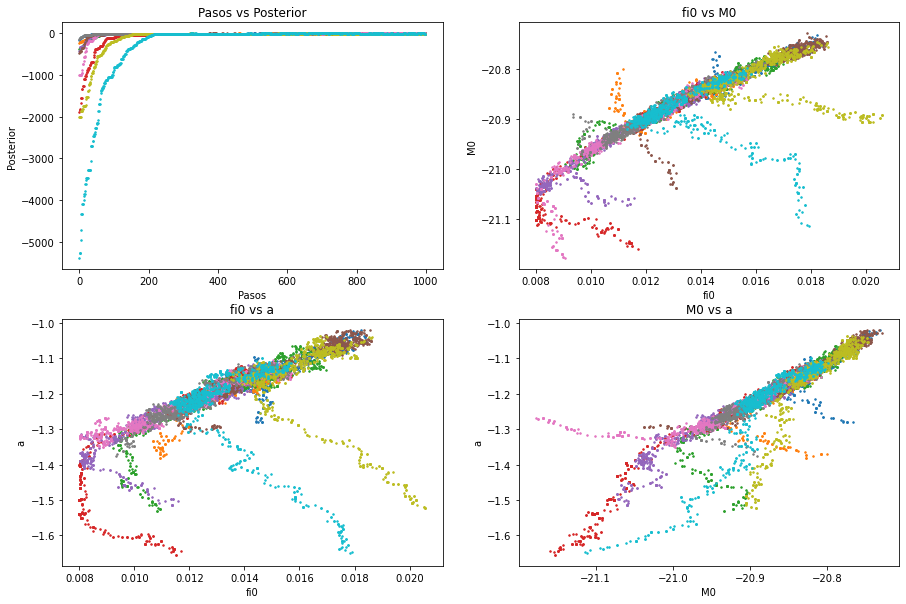

In [69]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
for i in range (10):
    plt.plot(pos2[i],'.',ms=3) # grafique los pasos
plt.title('Pasos vs Posterior')
plt.xlabel('Pasos')
plt.ylabel('Posterior')

plt.subplot(2,2,2)
for i in range (10):
    plt.plot(par2[i][:,0],par2[i][:,1],'.',ms=3)
plt.title('fi0 vs M0')
plt.xlabel('fi0')
plt.ylabel('M0')
    
plt.subplot(2,2,3)
for i in range (10):
    plt.plot(par2[i][:,0],par2[i][:,2],'.',ms=3)
plt.title('fi0 vs a')
plt.xlabel('fi0')
plt.ylabel('a')

plt.subplot(2,2,4)
for i in range (10):
    plt.plot(par2[i][:,1],par2[i][:,2],'.',ms=3)
plt.title('M0 vs a')
plt.xlabel('M0')
plt.ylabel('a')


plt.show()

Si bien parece ser que las cadenas siguen inicandosé en puntos bien distribuidos, esto es por la escala y por la forma en que se creó el mal mezclado.

##### **2.3.2. Segundo paso** 

Resta ver la comparación entre los buenos y malos mezclados. Para ello se verán gráficos parámetro vs pasos, en los cuales ser verán dos comportamientos: para el buen generador, se debe ver que las cadenas arrancan de puntos bien distribuidos en el espacio. Mientras que, en el mal generador se debería ver que las cadenas arrancan de puntos bastantes cercanos, es decir, no están bien distribuidos en el espacio. 

Los tres gráficos de la primera fila corresponden al buen mezclado, y los tres gráficos de la segunda fila corresponden al mal mezclado.

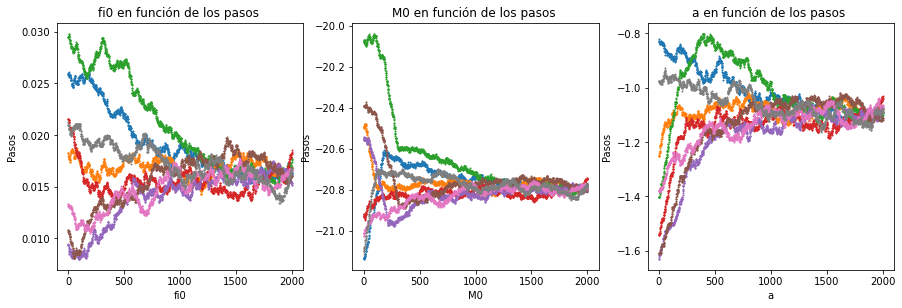

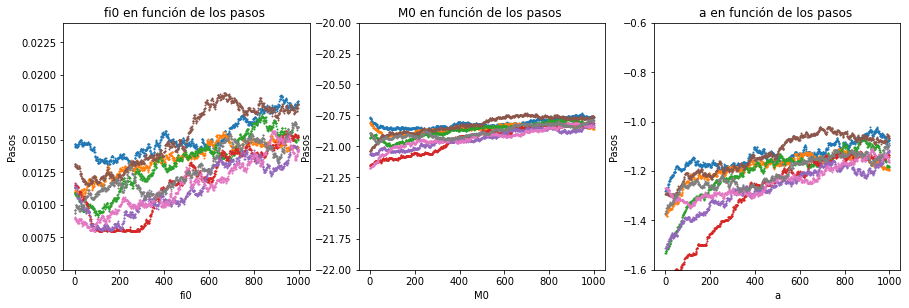

In [79]:
plt.figure(figsize = (15,10))
plt.subplot(2,3,1)
for i in range(8):
    plt.plot(par[i][:,0],'.', ms=2)
plt.title('fi0 en función de los pasos ')
plt.xlabel('fi0')
plt.ylabel('Pasos')

plt.subplot(2,3,2)
for i in range(8):
    plt.plot(par[i][:,1],'.', ms=2)
plt.title('M0 en función de los pasos ')
plt.xlabel('M0')
plt.ylabel('Pasos')

plt.subplot(2,3,3)    
for i in range(8):
    plt.plot(par[i][:,2],'.', ms=2)
plt.title('a en función de los pasos ')
plt.xlabel('a')
plt.ylabel('Pasos')

plt.figure(figsize = (15,10))
plt.subplot(2,3,4)
for i in range(8):
    plt.plot(par2[i][:,0],'.', ms=2)
plt.ylim(0.005,0.024) # probar con los limites de los parametros 
plt.title('fi0 en función de los pasos ')
plt.xlabel('fi0')
plt.ylabel('Pasos')

plt.subplot(2,3,5)
for i in range(8):
    plt.plot(par2[i][:,1],'.', ms=2)
plt.ylim(-22,-20) 
plt.title('M0 en función de los pasos ')
plt.xlabel('M0')
plt.ylabel('Pasos')

plt.subplot(2,3,6)    
for i in range(8):
    plt.plot(par2[i][:,2],'.', ms=2)
plt.ylim(-1.6,-0.6)
plt.title('a en función de los pasos ')
plt.xlabel('a')
plt.ylabel('Pasos')
plt.show()

En el caso del mal mezclado, graficandolo de esta manera, si es apreciable que los puntos iniciales arrancan todos cercanos en el espacio de parámetros. 

#### **2.4. Problema 5**

***Implemente el método del gradiente descendente para encontrar el mínimo (o máximo en este caso) del Likelihood marginalizando a cada uno de los parámetros. Discuta posibles cuestiones de precisión, conveniencias e inconveniencias con el método.***

##### **2.4.1. Primer paso**

Este método es un algoritmo de optimización que permite encontrar de formar aumática el mínimo de una función. Para ello se usa el gradiente (o derviada) de esa función, que permite "guiar" al algoritmo para que de manera progresiva se acerce al mínimo ideal de esa función (análogamente para el máximo).

Pero, ¿cómo funciona este algoritmo? primero que nada, es iteractivo, es decir que se repite el mismo proceso varias veces. Y, además de eso, requiere que se ingresen dos parámetros:
1) El número de veces que el proceso debe hacerse.
2) La tasa de aprendizaje, $\epsilon$, que define la cantidad de iteraciones necesarias para que el algoritmo encuentre el mínimo de la función. 

Luego de que esto dos parámetros fueron definidos, el agoritmo procede a escoger de manera aleatoria el valor de la variable w, y en cada iteración actualiza el valor de w, hasta completar el número de iteraciones definido por el usario.

* Para mas información: https://www.codificandobits.com/blog/el-gradiente-descendente/

Siguiente esta idea, es necesario obtener primero las componentes del gradiente en cada dirección, para ello se hace la derivada parcial del gradiente en cada una de las componentes (parámetros) y se divide por el módulo del cociente. 

In [43]:
def deriv1 (cata,f, fi0, M0, a, sigma): # derivada con respecto a fi0
    derivada1=[]
    #h=[]
    for i in range(len(f)):
        frida= -1/sigma[i]**2
        derivada1.append(frida*(f[i]-cata[i])*(cata[i]/fi0))
        #h.append(cata[i])
    s = np.sum(derivada1)
    return (s)
    

In [44]:
 deriv1 (cata, df['PHI'], 0.0146, -20.83 , -1.2, sigma) # valores de Balton

27304775.7239811

In [45]:
def deriv2 (cata,f,fi0,M0,a,sigma): # derivada con respecto a a
    derivada2=[]
    for i in range(len(f)):
        frida=-1/sigma[i]**2
        derivada2.append(frida*(f[i]-cata[i])*cata[i]*np.log(10)*(-0.4*(M[i]-M0)))
    s = np.sum(derivada2)
    return(s)


In [46]:
deriv2 (cata, df['PHI'], 0.0146, -20.83 , -1.2, sigma) # valores de Balton 

-1069341.3933516482

In [47]:
def deriv3 (cata,f, fi0, M0, a, sigma): # derivada con respecto a M0
    derivada3=[]
    for i in range(len(f)):
        frida= -1/sigma[i]**2
        g=-0.4*(M[i]-M0)
        derivada3.append(frida*(f[i]-cata[i])*cata[i]*np.log(10)*0.4*(a+1-10**g))
    s=np.sum(derivada3)
    return(s)


In [48]:
deriv3 (cata, df['PHI'], 0.0146, -20.83 , -1.2, sigma) # valores de Balton

-84658.96781018564

In [49]:
def modulo1(cata,f, fi0, M0, a, sigma):
    denominador=np.sqrt((deriv1 (cata,f, fi0, M0, a, sigma))**2 + (deriv2 (cata,f,fi0,M0,a,sigma)**2 + (deriv3 (cata,f, fi0, M0, a, sigma)**2)))
    modulo=deriv1 (cata,f, fi0, M0, a, sigma)/denominador
    return(modulo)

In [50]:
modulo1(cata,df['PHI'],0.0146, -20.83 , -1.2, sigma) # valores de Balton

0.9992292088034042

In [51]:
def modulo2(cata,f, fi0, M0, a, sigma):
    denominador=np.sqrt((deriv1 (cata,f, fi0, M0, a, sigma))**2 + (deriv2 (cata,f,fi0,M0,a,sigma)**2 + (deriv3 (cata,f, fi0, M0, a, sigma)**2)))
    modulo=deriv2 (cata,f, fi0, M0, a, sigma)/denominador
    return(modulo)

In [52]:
modulo2(cata,df['PHI'],0.0146, -20.83 , -1.2, sigma) # valores de Balton

-0.039132976781092746

In [53]:
def modulo3(cata,f, fi0, M0, a, sigma):
    denominador=np.sqrt((deriv1 (cata,f, fi0, M0, a, sigma))**2 + (deriv2 (cata,f,fi0,M0,a,sigma)**2 + (deriv3 (cata,f, fi0, M0, a, sigma)**2)))
    modulo=deriv3 (cata,f, fi0, M0, a, sigma)/denominador
    return(modulo)

In [54]:
modulo3(cata,df['PHI'],0.0146, -20.83 , -1.2, sigma) # valores de Balton

-0.0030981288503603463

Ahora resta definir el gradiente, cuyas componentes ya fueron calculadas.

In [55]:
def gradiente(cata,f, fi0, M0, a, sigma):
    grad= modulo1(cata,f,fi0,M0,a,sigma), modulo2(cata,f,fi0,M0,a,sigma), modulo3(cata,f,fi0,M0,a,sigma)
    return(grad)

Se evalúa el gradiente en los valores de Balton. 

In [56]:
gradiente(cata,f, 0.0146, -20.83, -1.2, sigma) # otros valores

(0.9992292088034042, -0.039132976781092746, -0.0030981288503603463)

Se calculan los versores para distintos parámetros.

In [57]:
primeralista=[]
for i in range(50):
    fi0= np.linspace(0.008,0.035)
    M0= np.linspace(-21.20,-20)
    a=np.linspace(-1.66,-0.66)
    primeralista.append(gradiente(cata,f,fi0[i],M0[i],a[i],sigma))
primeralista

[(0.9996950530457936, -0.02417815306479702, -0.005021735769951856),
 (0.9996574122873735, -0.02564970178234309, -0.005210648461461491),
 (0.9996183545706666, -0.02709625309389443, -0.005379430611554611),
 (0.9995779983283225, -0.028517807135237244, -0.005528104027717535),
 (0.9995364588751667, -0.029914364822640097, -0.005656691307661796),
 (0.9994938484092847, -0.03128592780203627, -0.0057652158297432105),
 (0.9994502760138175, -0.03263249839940053, -0.005853701744797146),
 (0.9994058476594341, -0.03395407957232533, -0.005922173969400957),
 (0.9993606662074548, -0.03525067486280064, -0.005970658180574253),
 (0.9993148314135929, -0.03652228835120088, -0.005999180811927832),
 (0.9992684399322931, -0.037768924611481666, -0.0060077690512717495),
 (0.9992215853216352, -0.03899058866758872, -0.005996450839693076),
 (0.9991743580487825, -0.040187285951079954, -0.005965254872113873),
 (0.9991268454959493, -0.041359022259962124, -0.005914210599339757),
 (0.9990791319668667, -0.0425058037187426

Ahora al gradiente se le va a dar de comer tres valores iniciales que se encuentren dentro de los límites de los parámetros.

In [58]:
gradiente(cata,f, 0.020, -21, -1.2, sigma)

(0.9983832864216172, -0.05668788828388539, -0.004158932060596119)

In [59]:
N=1000
r1=np.zeros((N,3))
r1[0,0]=0.020
r1[0,1]=-21
r1[0,2]=-1.2
for i in range(1,N):
    frida2=gradiente(cata,f,r1[i-1,0],r1[i-1,1],r1[i-1,2],sigma)
    r1[i]=r1[i-1]+[0.000006,0.01,0.001]*np.array(frida2) # salto y transforma la tupla en arreglo

#r1[:,2] # aca lo que se ve es que los parametros se mueven al rededor de los valores de Balton, es decir, anda bien algoritmo

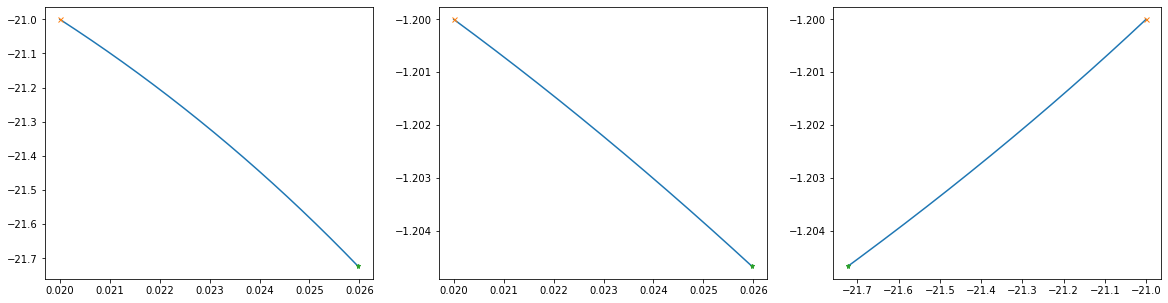

In [60]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(r1[:,0],r1[:,1], ms=5)
plt.plot(r1[0,0],r1[0,1], 'x', ms=5)
plt.plot(r1[-1,0],r1[-1,1], '*', ms=5)
plt.subplot(1,3,2)
plt.plot(r1[:,0],r1[:,2], ms=5)
plt.plot(r1[0,0],r1[0,2], 'x', ms=5)
plt.plot(r1[-1,0],r1[-1,2], '*', ms=5)
plt.subplot(1,3,3)
plt.plot(r1[:,1],r1[:,2], ms=5)
plt.plot(r1[0,1],r1[0,2], 'x', ms=5)
plt.plot(r1[-1,1],r1[-1,2], '*', ms=5)
plt.show()

Aca se ve hacia donde convergen.

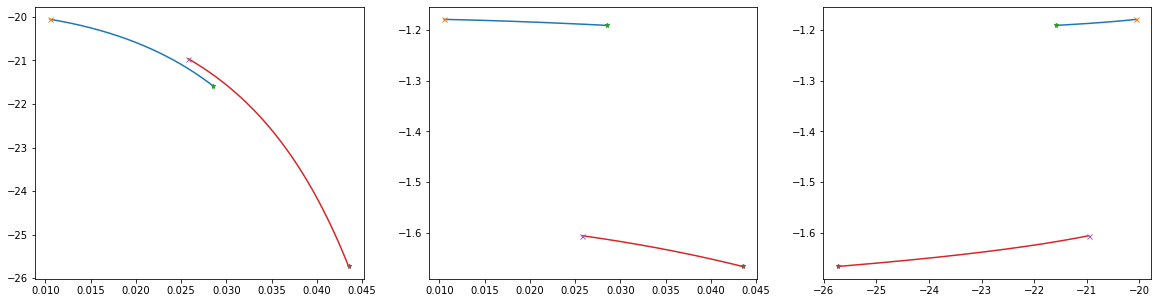

In [61]:
plt.figure(figsize=(20,5))
for j in range(2):
    genfi0= np.random.random()*0.022+0.008
    genM0=np.random.random()*1.2-21.20
    gena=np.random.random()*1-1.66
    N=3000
    r1=np.zeros((N,3))
    r1[0,0]=genfi0
    r1[0,1]=genM0
    r1[0,2]=gena
    for i in range(1,N):
        frida2=gradiente(cata,f,r1[i-1,0],r1[i-1,1],r1[i-1,2],sigma)
        r1[i]=r1[i-1]+[0.000006,0.01,0.001]*np.array(frida2)
       
    plt.subplot(1,3,1)
    plt.plot(r1[:,0],r1[:,1], ms=5)
    plt.plot(r1[0,0],r1[0,1], 'x', ms=5)
    plt.plot(r1[-1,0],r1[-1,1], '*', ms=5)
    plt.subplot(1,3,2)
    plt.plot(r1[:,0],r1[:,2], ms=5)
    plt.plot(r1[0,0],r1[0,2], 'x', ms=5)
    plt.plot(r1[-1,0],r1[-1,2], '*', ms=5)
    plt.subplot(1,3,3)
    plt.plot(r1[:,1],r1[:,2], ms=5)
    plt.plot(r1[0,1],r1[0,2], 'x', ms=5)
    plt.plot(r1[-1,1],r1[-1,2], '*', ms=5)
plt.show()